<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project 3-Neutron Transport and Scattering Through a Shielding Layer

Carys Siddle<br>
University of Manchester  
March 2023

Initialise python interpreter

In [1]:
#initialisation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.constants import Avogadro
import time
start_time = time.time()


#%matplotlib notebook #interactive
#%matplotlib notebook
#to stop it being interactive
# % matplotlib inline
#put this after interactive plots

In this project we will develop a simulation of neutrons travelling through a slab of material, considering only thermal neutrons, and the processes of absorbtion and scattering. The materials we will us and the properties of the materials we will need are listed below.

In [2]:
materials=np.array([['Water','Lead','Graphite'], #material
                   [0.6652*1e-24,0.158*1e-24,0.0045*1e-24], #absorbtion cm^2
                  [103.0*1e-24,11.221*1e-24,4.74*1e-24], # scattering cm^2
                  [1.00,11.35,1.67], #density g/cm^3
                   [18.0153,207.2,12.011]]) #molar mass g/mol

# Monte-Carlo method

Monte-Carlo is a statistical method of understanding systems using randomly generated numbers. You input those random numbers into a system to get a range of outcomes, the probability of each outcome can be found by looking at the total number of times it occurs and dividing by the total number of numbers inputted. The high the number of inputted values, the more accurate your probabilitites will be.

Given we will be using Monte Carlo techniques, we will need a random number generator. In realty a computer is unable to produce random numbers. However we don't need truly random numbers, we just need a sequence of numbers that is in no way correlated to the process we are looking at. Therefore we can use a pseudo random number generator. An example of a pseudo random number generator is a Linear Congruential Generator (LCG). Which takes a seed number, performs an operation on it to get the next number in the sequence, then repeats that operation on this number etc. While this method is good, the sequence of numbers will eventually repeat. Numpy also has a built in random number generator. Below we will compare both generators.

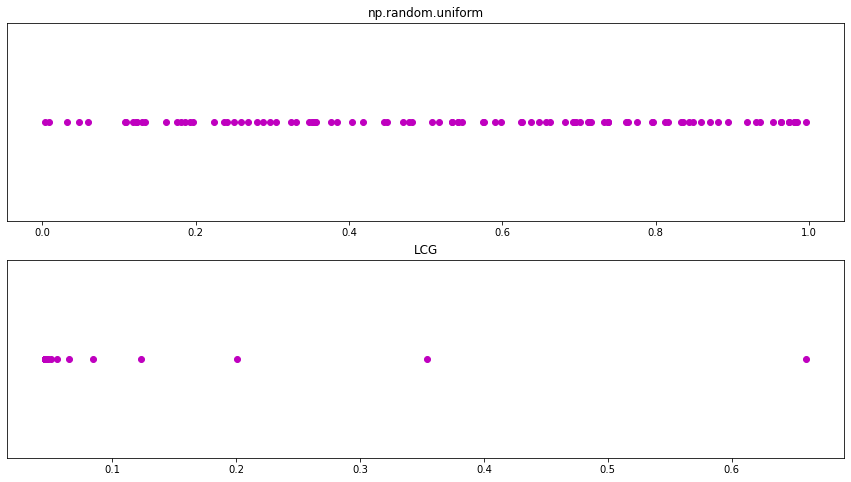

In [3]:
%matplotlib inline
def LCG(m,a,c,seed,num_num): #LCG function to generate random numbers 
    #best to use prime numbers, only works up to 2_D  
    array=np.array([seed])
    for i in range(0,num_num):
        new_num=np.mod((a*array[i]+c),m)
        new_num=new_num/m
        array=np.append(array,new_num)
    return array



numbers1=np.random.uniform(0,1,100) #set of random numbers using numpy
y=np.zeros(100)
fig_random_inline = plt.figure(figsize=(15,8))
ax=fig_random_inline.add_subplot(211)
ax.scatter(numbers1,y,color='m')
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax.set_title('np.random.uniform')
numbers2=LCG(1003,503,23,0.66,99) #set of random numbers using LCG function, choose input numbers
ax2=fig_random_inline.add_subplot(212)
ax2.scatter(numbers2,y,color='m')
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
ax2.set_title('LCG')

plt.show()

As we can see above, the in built numpy function appears to create a more uniform list of random numbers between 0 and 1. We can confirm this by creating a histogram of values producedby this function. A uniform function should have roughly the same frequency for values between 0 and 1 (i.e. the number of samples divided by the number of bins to give a mean). The majority of values generated should fall between the mean $\pm$ $\sqrt{(\frac{mean(no. samples- mean)}{no. samples})}$

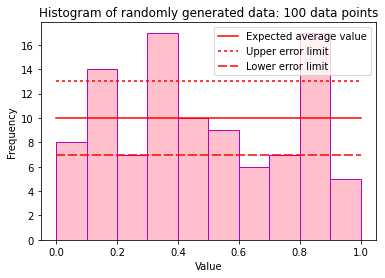

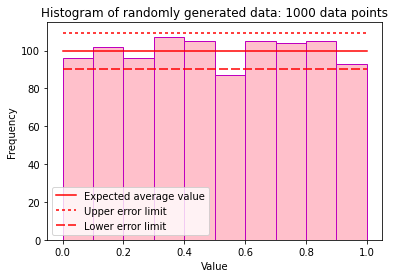

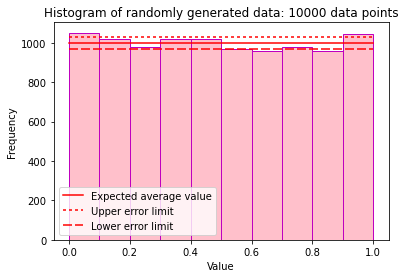

In [4]:
def uniform_check(nsamples): #function to check uniformity of np.random.uniform for a specified numober of samples
    no_bins=10
    numbers3=np.random.uniform(0,1,nsamples)
    num_freq,num_vals=np.histogram(numbers3,bins=no_bins,range=(0,1))
    num_vals= num_vals[:-1]
    av_bar=nsamples/no_bins #mean frequency of values if uniform
    error=np.sqrt((av_bar*(nsamples-av_bar))/nsamples)
    x = np.linspace(0, 1, 100)
    average_array=np.linspace(av_bar,av_bar,100)
    error_array1=np.linspace((error+av_bar),(error+av_bar),100)
    error_array2=np.linspace((av_bar-error),(av_bar-error),100)
    
    plt.plot(x,average_array, color='red', label=('Expected average value'))
    plt.plot(x,error_array1, color='red', label=('Upper error limit'),dashes=[2,2])
    plt.plot(x,error_array2, color='red', label=('Lower error limit'),dashes=[6,2])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of randomly generated data: {} data points'.format(str(nsamples)))
    plt.legend(loc='best')

    plt.bar(num_vals,num_freq,width=1/no_bins,color='pink',edgecolor='m',align='edge')
    plt.show()
    return None
uniform_check(100) 
uniform_check(1000)
uniform_check(10000)

As you can see above, as long as we have a sufficient number of of values generated, np.random.uniform is effectively uniform (majority of bins within our uncertainty limits). Therefore this is the random number generator we will use.

Now we will look at random numbers generated in 3-D. We will generated a list of random numbers for x,y and z coordinates then plot them on a 3-D axis.

<IPython.core.display.Javascript object>


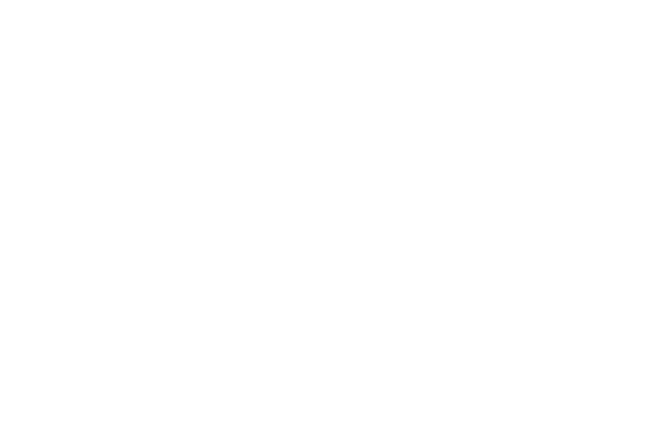

In [5]:
%matplotlib notebook
%matplotlib notebook
random_3d_fig=plt.figure()
x_val=np.random.uniform(0,1,1000) #random x coordinates
y_val=np.random.uniform(0,1,1000) #random y coordinates
z_val=np.random.uniform(0,1,1000) #random z coordinates
ax = plt.axes(projection="3d")
ax.set_title('Plot of randomly distributed x,y,z values')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(x_val,y_val,z_val,color='m')
plt.show()


We can see by looking at this plot from all angles, that we don't have the problem of spectral lines, i.e. some correlation between the points, which can often appear when using random numbers in 3-D. We can see an example of spectral lines in the plot below (code provided by demonstrators).

<IPython.core.display.Javascript object>


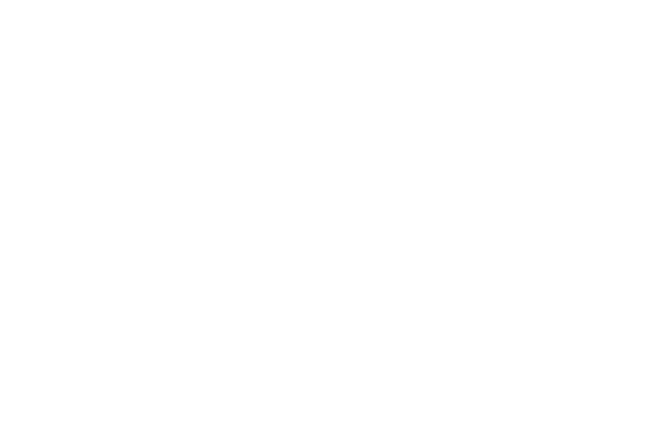

In [6]:
import numpy as np
 
#  RANDSSP Multiplicative congruential uniform random number generator.
#  Based on the parameters used by IBM's Scientific Subroutine Package.
#  The statement
#     r = randssp(m,n)
#  generates an m-by-n random matrix.
#  The function can not accept any other starting seed.
#
#  This function uses the "bad" generator parameters that IBM
#  used in several libraries in the 1960's.  There is a strong
#  serial correlation between three consecutive values.

def randssp(p,q): #randssp function provided by demonstrators
    
    global m, a, c, x
        
    #try: x
    #except NameError:
    m = pow(2, 31)
    a = pow(2, 16) + 3
    c = 0
    x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r


# In[214]:


k = randssp(3, 1500)


# In[215]:


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
%matplotlib notebook
%matplotlib notebook
get_ipython().magic('matplotlib notebook')
#using instead of %matplotlib inline for rotation

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(k[0, :], k[1, :], k[2, :], color='r')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

#print(k[:, 0])

If you look at the plot above approximately along the z-direction you can see clear planes, inidcative of some correlation between our pseudo random numbers (our x y and z have some correlation), which makes them decidely not random in 3-D. This is avoided in our random number generator. Using a random number generator with spectral line would affect the probabilities generated by our Monte-Carlo method, making them innaccurate.

We will now generate random numbers that are distributed according an exponential distribution $\exp(-\frac{x}{\lambda})$ We will do this by creating an inverse cdf of that function. $x=-\lambda*ln(u_i)$. Where $u_i$ is the random number between 0 and 1 determined by our random number generator. We will be looking at water (without scattering) for which $\lambda$ is 45cm (this is the nominal mean free path). From this we will create a histogram showing the frequency of different path lengths. We will repeat this several times to get an average frequency for each bin (and an error). We then need to delete any empty bins. Once this is done we can plot the resulting exponential function. We can take the log of our frequency values to get a linear plot and then we can use polyfit to find the attenuation length.

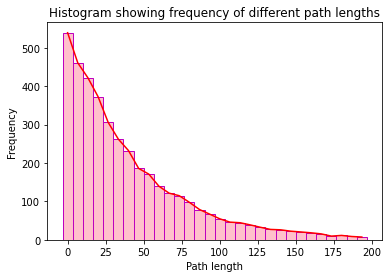

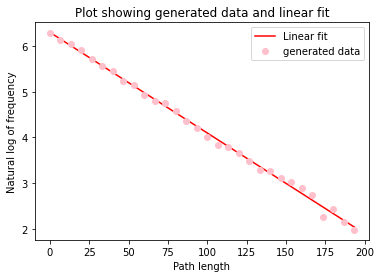

m:-0.0221 +/- 0.0002
lambda -1/m: 45.3366 +/- -0.3668


In [7]:
%matplotlib inline
lvalue=45 #cm
nparticles=4000
nbins=30
rmax=200 #limit on maximum value of distance
niterations=5
freq=np.zeros([niterations,nbins])

for iteration in range(niterations):
    distance=-lvalue*np.log(np.random.uniform(0,1,nparticles))
    freq[iteration,:],bin_loc=np.histogram(distance,bins=nbins,range=(0,rmax))
    bin_loc=bin_loc[:-1]

mean_freq=np.zeros(nbins)
std_freq=np.zeros(nbins)
for n in range(nbins): #find the average frequency for each bin
    mean_freq[n]=np.mean(freq[:,n])
    std_freq[n]=np.std(freq[:,n])

#remove zero frequency values from arrays   
std_freq=np.delete(std_freq,np.argwhere(mean_freq==0))
bin_loc=np.delete(bin_loc,np.argwhere(mean_freq==0))
mean_freq=np.delete(mean_freq,np.argwhere(mean_freq==0))

#plot histogram
plt.bar(bin_loc,mean_freq,width=(rmax/nbins),color='pink',edgecolor='m')
plt.plot(bin_loc,mean_freq,color='red')
plt.ylabel('Frequency')
plt.xlabel('Path length')
plt.title('Histogram showing frequency of different path lengths')
plt.show()

#find linear fit in order to find lambda
error_array=std_freq/mean_freq

linear_mean=np.log(mean_freq) #take the natural log of the mean frequencies to create a linear plot

plt.errorbar(bin_loc,linear_mean,color='pink',label='generated data', fmt='o')

fit_parameters, fit_errors = np.polyfit(bin_loc,linear_mean,1,cov=True,w=1/error_array)
m = fit_parameters[0]
c = fit_parameters[1]
uncert_m = np.sqrt(fit_errors[0][0])
uncert_c = np.sqrt(fit_errors[1][1])
y=m*bin_loc+c
plt.plot(bin_loc,y,label='Linear fit',color='r')
plt.legend()
plt.title('Plot showing generated data and linear fit')
plt.xlabel('Path length')
plt.ylabel('Natural log of frequency')
plt.show()
print('m:{:.4f} +/- {:.4f}'.format(m,uncert_m))
print('lambda -1/m: {:.4f} +/- {:.4f}'.format(-1/m, (-1/m)*(uncert_m/m))) #lambda value

As you can see our Monte-Carlo method finds the attenuation length to be around 45cm, matching what we set it to be. However it is not exactly 45cm due to some statistical error which we have stated.

We will now use our random number generator to plot random points on the surface of a sphere with radius 1. To do this we will use our random number generator to produce random angles in both $\phi$ and $\theta$. In order to avoid a higher density at the poles of the sphere, we have taken the inverse cdf of $\theta$.

<IPython.core.display.Javascript object>


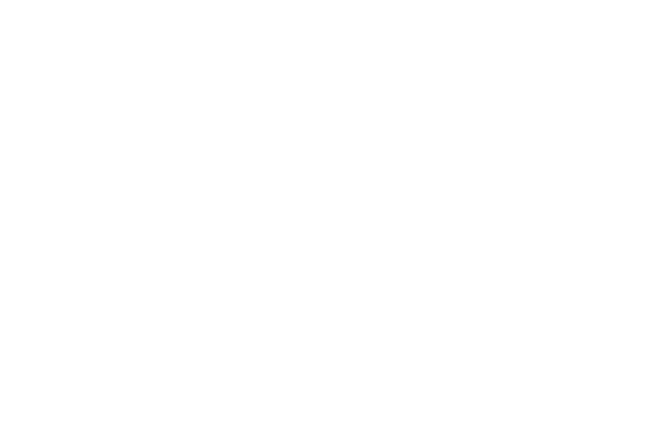

In [8]:
%matplotlib notebook
%matplotlib notebook
nparticles=1000
def sphere(distance): #function to generate uniformly distributed points on a sphere of radius distance
    r=distance
    theta=np.arccos(1-2*(np.random.uniform(0,1,nparticles)))
    phi=np.random.uniform(0,2*np.pi,nparticles)
    x=r*np.cos(phi)*np.sin(theta)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.cos(theta)
    return x,y,z
x,y,z=sphere(1) #set radius to 1
axis = plt.axes(projection="3d")
axis.set_title('Plot of randomly distributed x,y,z values on a sphere')
axis.set_xlabel('x')
axis.set_ylabel('y')
axis.set_zlabel('z')
axis.scatter(x,y,z, color='m')
plt.show()



As you can see all points are uniformly spread out over the surface of our sphere, as desired, again with no spectral lines.

# Isotropic steps

Given the motion of our neutrons is random in all directions, we will need to produce a step that is equally likely to be heading in all directions and has a length according to our exponential distribution. We will use both the exponential distribution of the step length and the methods in the sphere function above to plot this isotropic step, starting from the origin, to a random point. 

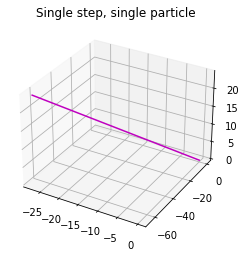

In [9]:
%matplotlib inline

axis = plt.axes(projection="3d") #makes 3d axis
def step(nparticles,lvalue): #function for an array of single steps for nparticles, length distributed exponentially
    r=-lvalue*np.log(np.random.uniform(0,1,nparticles))
    theta=np.arccos(1-2*(np.random.uniform(0,1,nparticles)))
    phi=np.random.uniform(0,2*np.pi,nparticles)
    x=r*np.cos(phi)*np.sin(theta)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.cos(theta)
    return x,y,z


stepx,stepy,stepz=step(1,45) #one particle
axis.plot([0, stepx[0]],[0,stepy[0]],[0,stepz[0]],color='m')
axis.set_title('Single step, single particle')

plt.show() 


We can use this same step function to plot a multiple step path.

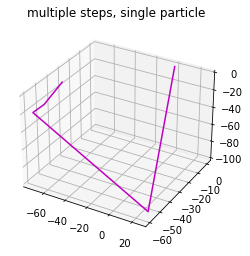

In [10]:

#single particle multiple steps
nsteps=6#number of steps the single particle will take
step_arrayx=np.zeros(nsteps)
step_arrayy=np.zeros(nsteps)
step_arrayz=np.zeros(nsteps)
for i in range (1,nsteps): #create an array of the particles position
    step_tempx,step_tempy,step_tempz=step(1,45)
    step_arrayx[i]=step_arrayx[i-1]+step_tempx
    step_arrayy[i]=step_arrayy[i-1]+step_tempy
    step_arrayz[i]=step_arrayz[i-1]+step_tempz
axis2=plt.axes(projection='3d')
axis2.plot(step_arrayx,step_arrayy,step_arrayz,color='m')#plot the steps the particle takes
axis2.set_title('multiple steps, single particle')
plt.show()

As we can see the steps are random in direction, with a random length (distributed according to our exponential function).

The function can also return a step for more than one particle.

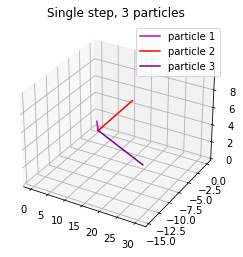

In [11]:


axis = plt.axes(projection="3d")
    
stepx,stepy,stepz=step(3,45)
axis.plot([0,stepx[0]],[0,stepy[0]],[0,stepz[0]],label='particle 1',color='m') #plot particle 1 step
axis.plot([0,stepx[1]],[0,stepy[1]],[0,stepz[1]],label='particle 2',color='red')#plot particle 2 step
axis.plot([0,stepx[2]],[0,stepy[2]],[0,stepz[2]],label='particle 3',color='purple')#plot particle 3 step
axis.set_title('Single step, 3 particles')
axis.legend(loc='best')

plt.show() 



# Nuetron model 

In order to model the transmission, absorbtion and reflection of neutrons, we need to know the total mean free path and total macroscopic cross-section for each material. This can be done using the information in our 2-D materials array. The total macroscopic cross-section ($\Sigma$) is equl to $\frac{\rho*N_A*\sigma}{M}$, where $\rho$ is the density (gcm$^{-3}$), M is the molar mass of the material and $\sigma$ is the microscopic-cross section. The mean free path ($\lambda$) is equal to $\frac{1}{\Sigma}$. The material has a $\Sigma$ value for both scattering and absorbtion, the total $\Sigma$ is just the sum of these to values, and the total $\lambda$ is just 1 over this total $\Sigma$.

In [12]:
%matplotlib inline
def print_func1(material,macro,lambda_val):#function to print mean free path and macroscopic cross section for a given material
    print('For {}, the mean free path is {:.4f} cm, the macroscopic cross section is {:.4f} cm^2'.format(material,lambda_val,macro))
    return None

def print_func2(material,macro_tot,lambda_tot):#function to print total mean free path and total macroscopic cross section for a given material
    print('For {}, the total mean free path is {:.4f} cm, the total macroscopic cross section is {:.4f} cm^2'.format(material,lambda_tot,macro_tot))

#water absorbtion macroscopic cross section and mean free path
macro_water_abs=(float(materials[3,0])*Avogadro/ float(materials[4,0]))*float(materials[1,0])
lambda_water_abs=1/(macro_water_abs) #mean free path 
#lead absorbtion macroscopic cross section and mean free path 
macro_lead_abs=(float(materials[3,1])*Avogadro/ float(materials[4,1]))*float(materials[1,1])
lambda_lead_abs=1/(macro_lead_abs) #mean free path 
#graphene absorbtion macroscopic cross section and mean free path 
macro_graphite_abs=(float(materials[3,2])*Avogadro/ float(materials[4,2]))*float(materials[1,2])
lambda_graphite_abs=1/(macro_graphite_abs) #mean free path 

print('ABSORBTION')
print_func1('Water',macro_water_abs,lambda_water_abs)
print_func1('Lead',macro_lead_abs,lambda_lead_abs)
print_func1('Graphite',macro_graphite_abs,lambda_graphite_abs)

#water scattering macroscopic cross section and mean free path
macro_water_scat=(float(materials[3,0])*Avogadro/ float(materials[4,0]))*float(materials[2,0])
lambda_water_scat=1/(macro_water_scat) #mean free path 
#lead scattering macroscopic cross section and mean free path
macro_lead_scat=(float(materials[3,1])*Avogadro/ float(materials[4,1]))*float(materials[2,1])
lambda_lead_scat=1/(macro_lead_scat) #mean free path 
#graphene scattering macroscopic cross section and mean free path
macro_graphite_scat=(float(materials[3,2])*Avogadro/ float(materials[4,2]))*float(materials[2,2])
lambda_graphite_scat=1/(macro_graphite_scat) #mean free path 

print('SCATTERING')
print_func1('Water',macro_water_scat,lambda_water_scat)
print_func1('Lead',macro_lead_scat,lambda_lead_scat)
print_func1('Graphite',macro_graphite_scat,lambda_graphite_scat)

#total macroscopic cross sections
macro_tot_water=macro_water_abs+macro_water_scat
macro_tot_lead=macro_lead_abs+macro_lead_scat
macro_tot_graphite=macro_graphite_abs+macro_graphite_scat
#total mean free paths
lambda_tot_water=1/macro_tot_water
lambda_tot_lead=1/macro_tot_lead
lambda_tot_graphite=1/macro_tot_graphite

print('TOTAL')
print_func2('Water',macro_tot_water,lambda_tot_water)
print_func2('Lead',macro_tot_lead,lambda_tot_lead)
print_func2('Graphite',macro_tot_graphite,lambda_tot_graphite)


ABSORBTION
For Water, the mean free path is 44.9716 cm, the macroscopic cross section is 0.0222 cm^2
For Lead, the mean free path is 191.8606 cm, the macroscopic cross section is 0.0052 cm^2
For Graphite, the mean free path is 2653.9900 cm, the macroscopic cross section is 0.0004 cm^2
SCATTERING
For Water, the mean free path is 0.2904 cm, the macroscopic cross section is 3.4431 cm^2
For Lead, the mean free path is 2.7015 cm, the macroscopic cross section is 0.3702 cm^2
For Graphite, the mean free path is 2.5196 cm, the macroscopic cross section is 0.3969 cm^2
TOTAL
For Water, the total mean free path is 0.2886 cm, the total macroscopic cross section is 3.4653 cm^2
For Lead, the total mean free path is 2.6640 cm, the total macroscopic cross section is 0.3754 cm^2
For Graphite, the total mean free path is 2.5172 cm, the total macroscopic cross section is 0.3973 cm^2


From this information we can the calculate the probability of absorbtion in each material, we will need this later when looking at the rates of absorbtion and the other processes.

In [13]:
#absorbtion probabilities for different materials
prob_abs_water=macro_water_abs/macro_tot_water
prob_abs_lead=macro_lead_abs/macro_tot_lead
prob_abs_graphite=macro_graphite_abs/macro_tot_graphite

print('The probability of absorbtion for water is {:.4f}'.format(prob_abs_water))
print('The probability of absorbtion for lead is {:.4f}'.format(prob_abs_lead))
print('The probability of absorbtion for graphite is {:.4f}'.format(prob_abs_graphite))

The probability of absorbtion for water is 0.0064
The probability of absorbtion for lead is 0.0139
The probability of absorbtion for graphite is 0.0009


We will use this information to simulate the transmission absorbtion and reflection of neutrons in our materials. Each neutron will start with an initial step of [r,0,0] (where r is a randomly generated step size) so it is entering the slab perpendicularly on its left side. We will then check if the particle has been absorbed by generating a random number between 1 and 0, if that number is below the probability of absorbtion, the particle is absorbed. We then check that the particle is still in the material (i.e. it's x value is greater than 0 but less than the thickness of the material). We will then generated a new step and repeat these checks, we will continue to do this until all the particles have either been absorbed of left the material.

First we will visualise the motion of only a few neutrons in each material

<IPython.core.display.Javascript object>


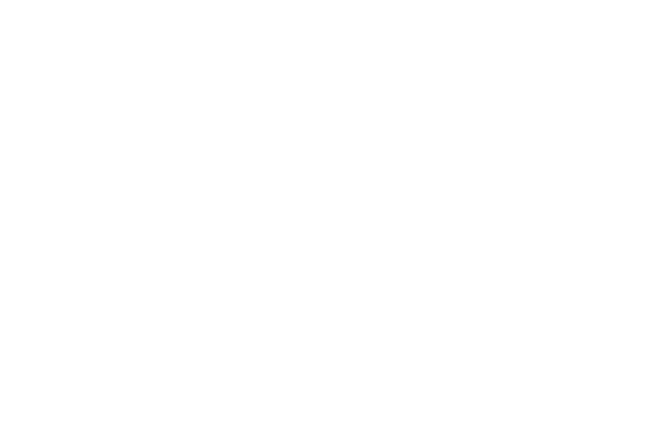

In [14]:
%matplotlib notebook
%matplotlib notebook
def travel_few(L,prob,lambda_val): #L is in cm
    # function for the motion of 1 particles in a material (assuming material is infinite in z and y directions)
    nparticles=1
    stepx_arr=-lambda_val*np.log(np.random.uniform(size=nparticles)) #initial step in x direction only
    stepy_arr=np.zeros(nparticles)
    stepz_arr=np.zeros(nparticles)
    
    total_trans=0
    total_abs=0
    total_ref=0
    total_particles=nparticles
    p_x=stepx_arr
    p_y=np.zeros(nparticles)
    p_z=np.zeros(nparticles)
    
    while nparticles>0:
        

        #count particles that have been reflected
        total_ref+=np.count_nonzero(stepx_arr<0)
        #count particles that have been transmitted
        total_trans+=np.count_nonzero(stepx_arr>L)
        #count absorbed particles
        numbers=np.random.uniform(0,1,nparticles) #generates random numbers to decided whether or not a neutron is absorbed
        total_abs+=np.count_nonzero(np.where(numbers<=prob))
        #update array
        stepy_arr=np.delete(stepx_arr,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=prob)))
        stepz_arr=np.delete(stepx_arr,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=prob)))
        stepx_arr=np.delete(stepx_arr,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=prob))) 
        
        #update number of particles
        nparticles=len(stepx_arr)
        #generates random steps
        stepx,stepy,stepz=step(nparticles,lambda_val)
        #adds to step array to update neutron position
        stepx_arr+=stepx
        stepy_arr+=stepy
        stepz_arr+=stepz
        
        p_x=np.append(p_x,stepx_arr)
        p_y=np.append(p_y,stepy_arr)
        p_z=np.append(p_z,stepz_arr)
 

    return p_x,p_y,p_z



L=5

px1_w,py1_w,pz1_w=travel_few(L,prob_abs_water,lambda_tot_water)
px2_w,py2_w,pz2_w=travel_few(L,prob_abs_water,lambda_tot_water)
px3_w,py3_w,pz3_w=travel_few(L,prob_abs_water,lambda_tot_water)
y_vals_maxw=np.max(np.array([np.max(py1_w),np.max(py2_w),np.max(py3_w)]))

Y_1=np.linspace(0,y_vals_maxw,10)
X_1=np.zeros(10)
Z_1=np.zeros(10)
X_2=np.linspace(L,L,10)


axis_w = plt.axes(projection="3d")
axis_w.plot(X_1,Y_1,Z_1,color='k',label='Material limits')
axis_w.plot(X_2,Y_1,Z_1,color='k')
axis_w.plot(px1_w,py1_w,pz1_w, color='m',label='Particle 1')
axis_w.plot(px2_w,py2_w,pz2_w, color='pink',label='Particle 2')
axis_w.plot(px3_w,py3_w,pz3_w, color='red',label='Particle 3')
axis_w.set_title('Motion of three particles through 5cm of water')
axis_w.legend(loc='best')
plt.show()


<IPython.core.display.Javascript object>


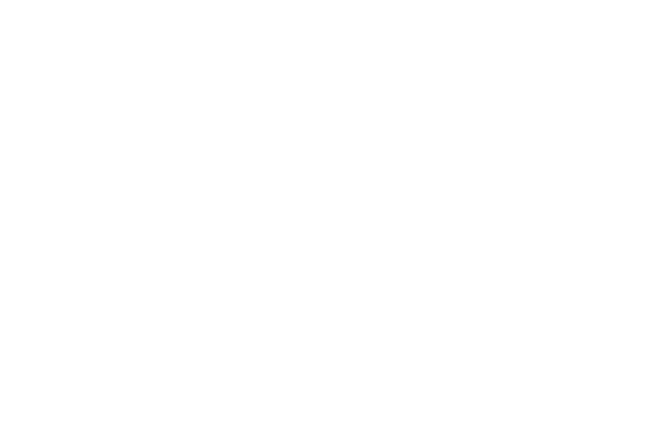

In [15]:
%matplotlib notebook
%matplotlib notebook

px1_l,py1_l,pz1_l=travel_few(L,prob_abs_lead,lambda_tot_lead)
px2_l,py2_l,pz2_l=travel_few(L,prob_abs_lead,lambda_tot_lead)
px3_l,py3_l,pz3_l=travel_few(L,prob_abs_lead,lambda_tot_lead)


y_vals_maxl=np.max(np.array([np.max(py1_l),np.max(py2_l),np.max(py3_l)]))

Y_1=np.linspace(0,y_vals_maxl,10)

axis_l = plt.axes(projection="3d")

axis_l.plot(px1_l,py1_l,pz1_l, color='m',label='Particle 1')
axis_l.plot(px2_l,py2_l,pz2_l, color='pink',label='Particle 2')
axis_l.plot(px3_l,py3_l,pz3_l, color='red',label='Particle 3')
axis_l.set_xlim(-1,6)
axis_l.set_title('Motion of three particles through 5cm of lead')
axis_l.legend(loc='best')


plt.show()

<IPython.core.display.Javascript object>


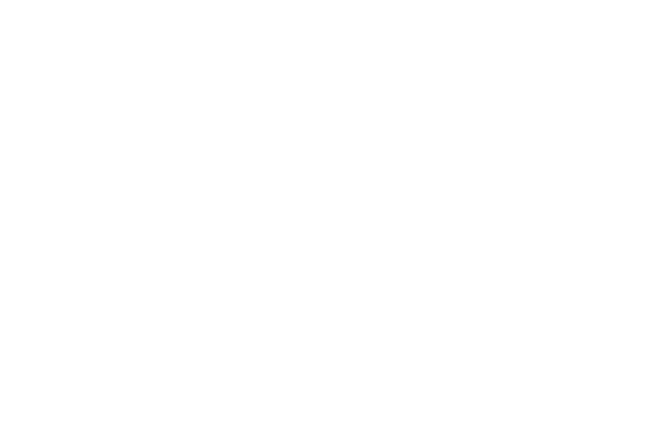

In [16]:
%matplotlib notebook
%matplotlib notebook


px1_g,py1_g,pz1_g=travel_few(L,prob_abs_graphite,lambda_tot_graphite)
px2_g,py2_g,pz2_g=travel_few(L,prob_abs_graphite,lambda_tot_graphite)
px3_g,py3_g,pz3_g=travel_few(L,prob_abs_graphite,lambda_tot_graphite)
y_vals_maxg=np.max(np.array([np.max(py1_g),np.max(py2_g),np.max(py3_g)]))

Y_1=np.linspace(0,y_vals_maxg,10)

axis_g = plt.axes(projection="3d")
axis_g.plot(X_1,Y_1,Z_1,color='k',label='Material limits')
axis_g.plot(X_2,Y_1,Z_1,color='k')
axis_g.plot(px1_g,py1_g,pz1_g, color='m',label='Particle 1')
axis_g.plot(px2_g,py2_g,pz2_g, color='pink',label='Particle 2')
axis_g.plot(px3_g,py3_g,pz3_g, color='red',label='Particle 3')
axis_g.set_xlim(-1,6)
axis_g.set_title('Motion of three particles through 5cm of graphite')
axis_g.legend(loc='best')


plt.show()

As you can see in each material each particle takes random steps until they are absorbed or have left the material

Now we will simulate the motion of thousands of particles, to get accurate transmission, absorbtion and reflection rates for each material.

In [17]:
%matplotlib inline
def travel(nparticles,L,prob,lambda_val): #L is in cm
    # function for the motion of n particles in a material (assuming material is infinite in z and y directions)
    stepx_arr=-lambda_val*np.log(np.random.uniform(size=nparticles)) #initial step in x direction only
    total_trans=0
    total_abs=0
    total_ref=0
    total_particles=nparticles
    
    while nparticles>0:
        

        #count particles that have been reflected
        total_ref+=np.count_nonzero(stepx_arr<0)
        #count particles that have been transmitted
        total_trans+=np.count_nonzero(stepx_arr>L)
        #count absorbed particles
        numbers=np.random.uniform(0,1,nparticles) #generates random numbers to decided whether or not a neutron is absorbed
        total_abs+=np.count_nonzero(np.where(numbers<=prob))
        #update array
        stepx_arr=np.delete(stepx_arr,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=prob))) 
        #update number of particles
        nparticles=len(stepx_arr)
        #generates random steps
        stepx,stepy,stepz=step(nparticles,lambda_val)
        #adds to step array to update neutron position
        stepx_arr+=stepx
    #calculate rates   
    rate_abs=total_abs/total_particles #fraction of particles absorbed
    rate_ref=total_ref/total_particles #fraction of particles reflected
    rate_trans=total_trans/total_particles #fraction of perticles transmitted
    return rate_abs,rate_trans,rate_ref

In order to get an accurate idea of the rates of absorbtion, transmission and reflection are, we will need to repeat the function above several times and then take the average, we will then take the uncertainty to be the standard deviation of the mean. Initially we will be doing this for a material of thickness 10cm. While increasing the number of particles will help us get a more accurate value for the rates, it is important to note the actual rates do not depend on particle number.

WATER
For Water, the rate of absorbtion is 0.2067 +/- 0.0047, for a thickness of 10 cm and 10000 particles
For Water, the rate of reflection is 0.7947 +/- 0.0048, for a thickness of 10 cm and 10000 particles
For Water, the rate of transmission is 0.0031 +/- 0.0004, for a thickness of 10 cm and 10000 particles
LEAD
For Lead, the rate of absorbtion is 0.1108 +/- 0.0035, for a thickness of 10 cm and 10000 particles
For Lead, the rate of reflection is 0.6208 +/- 0.0050, for a thickness of 10 cm and 10000 particles
For Lead, the rate of transmission is 0.2809 +/- 0.0048, for a thickness of 10 cm and 10000 particles
GRAPHITE
For Graphite, the rate of absorbtion is 0.0089 +/- 0.0006, for a thickness of 10 cm and 10000 particles
For Graphite, the rate of reflection is 0.6847 +/- 0.0050, for a thickness of 10 cm and 10000 particles
For Graphite, the rate of transmission is 0.3074 +/- 0.0051, for a thickness of 10 cm and 10000 particles


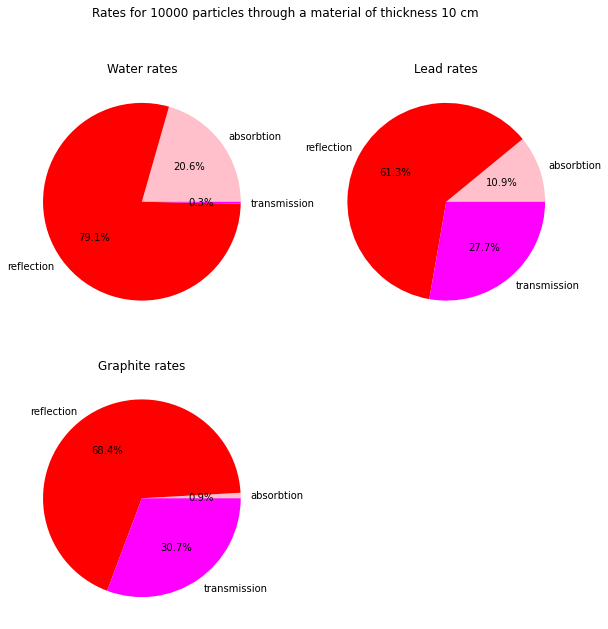

In [18]:
def average_rates(niter,prob,lambda_val,nparticles,L):
    #function to find the average rates
    rate_abs_array=np.zeros(niter)
    rate_ref_array=np.zeros(niter)
    rate_trans_array=np.zeros(niter)
    for i in range (0,niter): #create an array of different rates
        abs_val,trans,ref=travel(nparticles,L,prob,lambda_val)
        rate_abs_array[i]=abs_val
        rate_ref_array[i]=ref
        rate_trans_array[i]=trans
    #find averages and errors
    av_abs_rate=np.mean(rate_abs_array)
    av_abs_rate_er=np.std(rate_abs_array)
    av_ref_rate=np.mean(rate_ref_array)
    av_ref_rate_er=np.std(rate_ref_array)
    av_trans_rate=np.mean(rate_trans_array)
    av_trans_rate_er=np.std(rate_trans_array)
    return np.array([av_abs_rate, av_abs_rate_er,av_ref_rate, av_ref_rate_er,av_trans_rate, av_trans_rate_er])

def print_func3(material,process,rate,error,L, nparticles): #function to print a given rate for a given material
    print('For {}, the rate of {} is {:.4f} +/- {:.4f}, for a thickness of {} cm and {} particles'.format(material,process,rate,error,L,nparticles))
    return None

no_particles=10000 #needs to be large eneough for np.random.uniform to be appropriately random
thickness=10 #cm
niter=15 #'number of iterations'

print('WATER') #water rates
water_rates1=average_rates(niter,prob_abs_water,lambda_tot_water,no_particles,thickness)
print_func3('Water','absorbtion',water_rates1[0],water_rates1[1],thickness,no_particles)
print_func3('Water','reflection',water_rates1[2],water_rates1[3],thickness,no_particles)
print_func3('Water','transmission',water_rates1[4],water_rates1[5],thickness,no_particles)
print('LEAD')#lead rates
lead_rates1=average_rates(niter,prob_abs_lead,lambda_tot_lead,no_particles,thickness)
print_func3('Lead','absorbtion',lead_rates1[0],lead_rates1[1],thickness,no_particles)
print_func3('Lead','reflection',lead_rates1[2],lead_rates1[3],thickness,no_particles)
print_func3('Lead','transmission',lead_rates1[4],lead_rates1[5],thickness,no_particles)
print('GRAPHITE')#graphite rates
graphite_rates1=average_rates(niter,prob_abs_graphite,lambda_tot_graphite,no_particles,thickness)
print_func3('Graphite','absorbtion',graphite_rates1[0],graphite_rates1[1],thickness,no_particles)
print_func3('Graphite','reflection',graphite_rates1[2],graphite_rates1[3],thickness,no_particles)
print_func3('Graphite','transmission',graphite_rates1[4],graphite_rates1[5],thickness,no_particles)

#create pie charts to better demonstrate rates
fig_pie=plt.figure(figsize=[10,10])
fig_pie.suptitle('Rates for {} particles through a material of thickness {} cm'.format(no_particles,thickness))
labels_val = 'absorbtion', 'reflection', 'transmission'
rates_water = [water_rates1[0], water_rates1[2],water_rates1[4]]
ax_water = fig_pie.add_subplot(221)
ax_water.pie(rates_water, labels=labels_val,autopct='%1.1f%%',colors=['pink','red','magenta'],normalize=True)
ax_water.set_title('Water rates')

rates_lead = [lead_rates1[0], lead_rates1[2],lead_rates1[4]]
ax_lead = fig_pie.add_subplot(222)
ax_lead.pie(rates_lead, labels=labels_val,autopct='%1.1f%%',colors=['pink','red','magenta'],normalize=True)
ax_lead.set_title('Lead rates')

rates_graphite = [graphite_rates1[0], graphite_rates1[2],graphite_rates1[4]]
ax_graphite = fig_pie.add_subplot(223)
ax_graphite.pie(rates_graphite, labels=labels_val,autopct='%1.1f%%',colors=['pink','red','magenta'],normalize=True)
ax_graphite.set_title('Graphite rates')

plt.show()

As we can see water had the largest proportion of neutrons absorbed, this makes sense as it had the cross section for absorbtion and vice versa for graphite. It is worth noting that although we have specified the number of particles, this would not make a difference to the actual rates only the accuracy of the rates we have found.

Now we will look at how the thickness of the material affects the rates transmission, reflection and absorbtion. We would expect the rates of transmission to go down and the rates of absorbtion and reflection to go up for greater thicknesses.

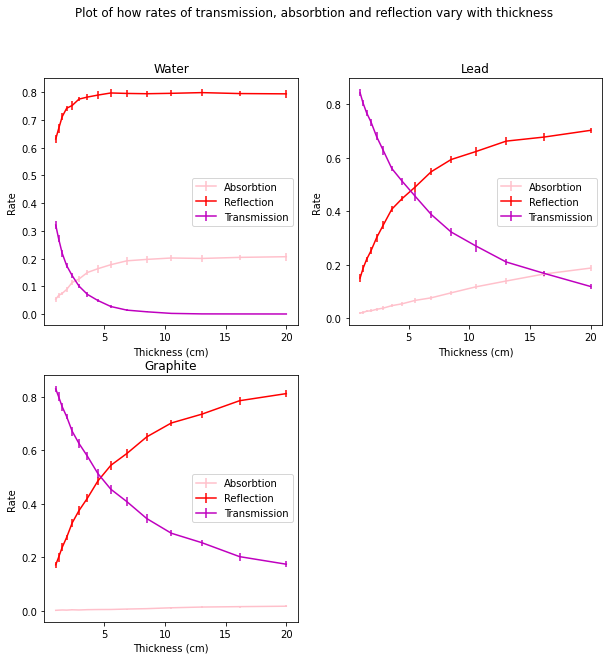

In [19]:
thickness_array=np.geomspace(1,20,15) #chosen to use np.geomspace so we have more points before the plateu

def thickness_plot(prob,lambda_val,thickness_array):
    #function to plot how thickness affects different rates for a given material
    niter=15
    no_particles=1000
    trans_array=np.zeros(len(thickness_array))
    ref_array=np.zeros(len(thickness_array))
    abs_array=np.zeros(len(thickness_array))
    trans_array_er=np.zeros(len(thickness_array))
    ref_array_er=np.zeros(len(thickness_array))
    abs_array_er=np.zeros(len(thickness_array))

    for i in range(0,len(thickness_array)):
        abs_array[i],abs_array_er[i],ref_array[i],ref_array_er[i],trans_array[i],trans_array_er[i]=average_rates(niter,prob,lambda_val,no_particles,thickness_array[i])
        
    return np.array([abs_array,abs_array_er,ref_array,ref_array_er,trans_array,trans_array_er])

#find thickness dependent rates for each material
water_thick=thickness_plot(prob_abs_water,lambda_tot_water,thickness_array)
lead_thick=thickness_plot(prob_abs_lead,lambda_tot_lead,thickness_array)
graphite_thick=thickness_plot(prob_abs_graphite,lambda_tot_graphite,thickness_array)

#plot rates against thickness for all materials
fig_thick=plt.figure(figsize=[10,10])
fig_thick.suptitle('Plot of how rates of transmission, absorbtion and reflection vary with thickness')
axes_water=fig_thick.add_subplot(221)
axes_water.errorbar(thickness_array,water_thick[0],water_thick[1],label='Absorbtion',color='pink')
axes_water.errorbar(thickness_array,water_thick[2],water_thick[3],label='Reflection',color='red') 
axes_water.errorbar(thickness_array,water_thick[4],water_thick[5],label='Transmission',color='m') 
axes_water.set_title('Water')
axes_water.set_xlabel('Thickness (cm)')
axes_water.set_ylabel('Rate')
axes_water.legend(loc='best')

axes_lead=fig_thick.add_subplot(222)
axes_lead.errorbar(thickness_array,lead_thick[0],lead_thick[1],label='Absorbtion',color='pink')
axes_lead.errorbar(thickness_array,lead_thick[2],lead_thick[3],label='Reflection',color='red') 
axes_lead.errorbar(thickness_array,lead_thick[4],lead_thick[5],label='Transmission',color='m') 
axes_lead.set_title('Lead')
axes_lead.set_xlabel('Thickness (cm)')
axes_lead.set_ylabel('Rate')
axes_lead.legend(loc='best')

axes_graphite=fig_thick.add_subplot(223)
axes_graphite.errorbar(thickness_array,graphite_thick[0],graphite_thick[1],label='Absorbtion',color='pink')
axes_graphite.errorbar(thickness_array,graphite_thick[2],graphite_thick[3],label='Reflection',color='red') 
axes_graphite.errorbar(thickness_array,graphite_thick[4],graphite_thick[5],label='Transmission',color='m') 
axes_graphite.set_title('Graphite')
axes_graphite.set_xlabel('Thickness (cm)')
axes_graphite.set_ylabel('Rate')
axes_graphite.legend(loc='best')


plt.show()





As expected, trasmission decreases with thickness, absorbtion and reflection increases. The change is transmission in not linear but exponential.

We will now attempt to get a value for the attenuation lengths for each material. In order to work out the characteristic attenuation length for each material, we will look at the how the transmission rate varies with thickness. The attenuation length is the length at which the rate of transmission will have decrease by 1/e. To find this value we will plot the natural log of the rates against the thickness, (which should be linear) and then use np.polyfit to find the gradient (m), the attenuation length will be $\frac{-1}{m}$

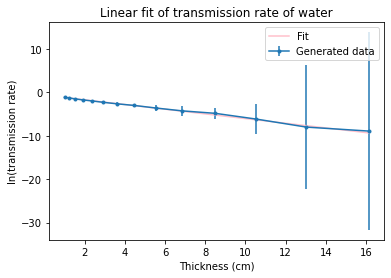

The characteristic attenuation length of water is 1.858 +/- -0.051 cm
The reduced chi squared of this fit is 0.269


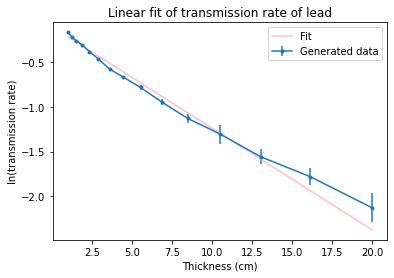

The characteristic attenuation length of lead is 8.814 +/- -0.357 cm
The reduced chi squared of this fit is 39.431


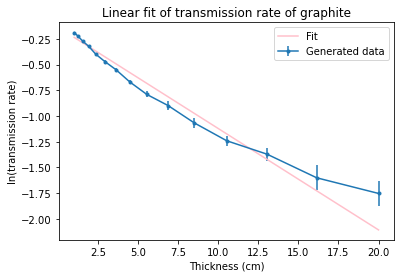

The characteristic attenuation length of graphite is 10.148 +/- -0.531 cm
The reduced chi squared of this fit is 39.171


In [20]:

def transmission_func(atten,thick):
    trans=np.exp(-thick/atten)
    return trans

def chi_squared( atten,x, y_value, y_uncertainty,y_fit):

    chi = np.sum(((y_fit-y_value)/y_uncertainty)**2)
    return chi

def reduced_chi(degrees_of_freedom, chi_squared_in):
    reduced = chi_squared_in/degrees_of_freedom
    return reduced




def attenuation(material,linear_fit, thickness_array, linear_fit_error):
    #funtction finds the attenuation length based on the linear fit of transmission rate for a given material
    fit_parameters, fit_errors = np.polyfit(thickness_array,linear_fit,1,cov=True,w=linear_fit/linear_fit_error)
    m = fit_parameters[0]
    c = fit_parameters[1]
    uncert_m = np.sqrt(fit_errors[0][0])
    uncert_c = np.sqrt(fit_errors[1][1])
    y=m*thickness_array+c
    plt.plot(thickness_array,y,label='Fit',color='pink')
    plt.errorbar(thickness_array,linear_fit,linear_fit_error,marker='.', label='Generated data')
    plt.legend(loc='best')
    plt.xlabel('Thickness (cm)')
    plt.ylabel('ln(transmission rate)')
    plt.title('Linear fit of transmission rate of {}'.format(material))
    plt.show()
    attenuation=-1/m
    attenuation_er= attenuation*(uncert_m/m)
    print('The characteristic attenuation length of {} is {:.3f} +/- {:.3f} cm'.format(material,attenuation,attenuation_er))
    chi=chi_squared(attenuation,thickness_array,linear_fit,linear_fit_error,y)
    dof=len(thickness_array)-2
    reduced=reduced_chi(dof,chi)
    print('The reduced chi squared of this fit is {:.3f}'.format(reduced))
    
    return attenuation
    
    
def delete(x,y,z): #delete any cases where rate is 0
    y=np.delete(y,np.argwhere(x==0))
    z=np.delete(z,np.argwhere(x==0))
    x=np.delete(x,np.argwhere(x==0))
    
    return x,y,z

#linear fit for water
water_thick_rate,water_thick_rate_er,thickness_array1=delete(water_thick[4],water_thick[5],thickness_array)
water_linear_trans=np.log(water_thick_rate)
water_linear_trans_er=water_linear_trans*(water_thick_rate_er/water_thick_rate)
#linear fit for lead
lead_thick_rate,lead_thick_rate_er,thickness_array2=delete(lead_thick[4],lead_thick[5],thickness_array)
lead_linear_trans=np.log(lead_thick_rate)
lead_linear_trans_er=lead_linear_trans*(lead_thick_rate_er/lead_thick_rate)
#linear fit for graphite
graphite_thick_rate,graphite_thick_rate_er,thickness_array3=delete(graphite_thick[4],graphite_thick[5],thickness_array)
graphite_linear_trans=np.log(graphite_thick_rate)
graphite_linear_trans_er=graphite_linear_trans*(graphite_thick_rate_er/graphite_thick_rate)

#finding attentuation length
atten_w=attenuation('water',water_linear_trans,thickness_array1,water_linear_trans_er)
atten_l=attenuation('lead',lead_linear_trans,thickness_array2,lead_linear_trans_er)
atten_g=attenuation('graphite',graphite_linear_trans,thickness_array3,graphite_linear_trans_er)

As you can see, as the thickness of the material increases, the natural log of the rate of transmission moves away from a linear fit, this is especially obvious in lead and graphite. From these attenuation lengths we can predict what percentage of neutrons are transmitted, given the thickness of a material. You can see some examples of this below.

In [21]:
def transmission_func2(material,atten,thick):
    #function to return transmission rates of a given material at a given thickness
    trans=np.exp(-thick/atten)
    print('For a piece of {} cm thick {}, {:.4f} of particles are transmitted'.format(thick,material,trans))
    
    return None

transmission_func2('water',atten_w,0.01)
transmission_func2('lead',atten_l,50)
transmission_func2('graphite',atten_g,3)

For a piece of 0.01 cm thick water, 0.9946 of particles are transmitted
For a piece of 50 cm thick lead, 0.0034 of particles are transmitted
For a piece of 3 cm thick graphite, 0.7441 of particles are transmitted


# Woodcock Method


We will now use the Woodcock method to calculate the fraction of neutrons transmitted through two slabs of different materials in contact with each other. 

When we have two different materials, we will have two different macroscopic cross-sections ($\Sigma$) and therefore two different values for the mean free path. In the woodock method we use the smallest mean free path in both materials. In the region with the longer mean free path, we have obviously taken a step that is too short, to account for this we have something call a ficticious step, we take this step in the same direction as the 'real' step. The length of this step is $\frac{1}{\Sigma_f}$ where $\Sigma_f$ is the  $\Sigma_T - \Sigma_i$ where $\Sigma_i$ is the $\Sigma$ value of the material the neutron is in and $\Sigma_T$ is the largest $\Sigma$.

At each step there is a probability the step will not have a ficticous step is $\frac{\Sigma_i}{\Sigma_T}$, so when we are in the material with the smallest mean free path (largest $\Sigma$) we will never have a ficticious step. After each ficticious step we check whether the nuetron is still in material as we have done before and whether it has been absorbed. WE repeat until all particles have either been absorbed or left the block

Initally we will use the woodcock method for a block of 10cm thick water next to a block of 10cm thick lead.

In [22]:
def cross_choice(sigma1,sigma2): #function to find the larger sigma value
    array=np.array([sigma1,sigma2])
    larger=np.max(array)
    return larger

def prob_fic(sigmai,sigma_tot): #function to find the probablity of a ficticious step
    prob=(sigmai)/sigma_tot
    return prob
    

def sigma_array(sigma1,sigma2,L1,L2,arrx): 
    #function to create an array of sigmas where the value depends on the material the neutron is in
    sigma=np.zeros(len(arrx))
    loc1=np.where(arrx<L1)
    sigma[loc1]=sigma1
    loc2=np.where(arrx>=L1)
    sigma[loc2]=sigma2
    return sigma

def next_step(theta,phi,lambda_val,fic,sigma_total,sigma,nparticles):
    #function to create a step depending on whether it is 'real' or fictitious
    fic_step_l=np.zeros(len(sigma))
    sigma[(np.argwhere(sigma==sigma_total))]=0.0000001
    fic_step_l[np.argwhere(sigma!=sigma_total)]=(1/(sigma_total-sigma))[np.argwhere(sigma!=sigma_total)]
    fic_step_len=-(fic_step_l)*np.log(np.random.uniform(0,1,nparticles))
        
    r=-lambda_val*np.log(np.random.uniform(0,1,nparticles))
    theta_new=np.arccos(1-2*(np.random.uniform(0,1,nparticles)))
    phi_new=np.random.uniform(0,2*np.pi,nparticles)
    
    theta[np.argwhere(fic==False)]=theta_new[np.argwhere(fic==False)]
    phi[np.argwhere(fic==False)]=phi_new[np.argwhere(fic==False)]
    r[np.argwhere(fic==True)]=fic_step_len[np.argwhere(fic==True)]
    
    x=r*np.cos(phi)*np.sin(theta)
    return x,theta,phi

def travel_woodcock3(nparticles,L1,L2,prob_abs1,prob_abs2,sigma1,sigma2): #L is in cm
    #function to use woodcock method to find rates of transmission, absorbtion and reflection for a block consisting of two materials
    sigma_total=(cross_choice(sigma1,sigma2))
    lambda_val=1/sigma_total
    stepx_arr=-lambda_val*np.log(np.random.uniform(size=nparticles)) #make length random
    theta_arr=np.full(nparticles,np.pi/2)
    phi_arr=np.full(nparticles,0)
    total_trans=0
    total_abs=0
    total_ref=0
    total_particles=nparticles
    L=L1+L2
        
    
    while nparticles>0: #loop while there are still particles in the block
        #gets sigma array
        sigma=sigma_array(sigma1,sigma2,L1,L2,stepx_arr)
        #gets probability array
        prob_f=prob_fic(sigma,sigma_total)
        #count particles that have been reflected
        total_ref+=np.count_nonzero(stepx_arr<0)
        #count particles that have been transmitted
        total_trans+=np.count_nonzero(stepx_arr>L)
        #generated an array of true and false values depending on whether or no a step is fictitious
        v=np.random.uniform(size=nparticles)
        ficticious=np.full(nparticles,False)
        ficticious[np.argwhere((stepx_arr>0)&(stepx_arr<L)&(v>prob_f))]=True

        #update theta and phi arrays and produce array of next steps
        stepx,theta_arr,phi_arr=next_step(theta_arr,phi_arr,lambda_val,ficticious,sigma_total,sigma,nparticles)
        
        #create an array for the probability of absorbtion by each particle depending on what material it is in
        probs_array=np.zeros(len(stepx_arr))
        numbers=np.random.uniform(0,1,nparticles)#random numbers generated to decide wherher or not a neutron is absorbed
        probs_array[np.where(stepx_arr<L1)]=prob_abs1
        probs_array[np.where(stepx_arr>=L1)]=prob_abs2
        total_abs+=np.count_nonzero(((numbers<=probs_array)&(stepx_arr>0)&(stepx_arr<L)))

        #update all arrays and particle number
        theta_arr=np.delete(theta_arr,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=probs_array)))
        phi_arr=np.delete(phi_arr,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=probs_array)))
        stepx=np.delete(stepx,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=probs_array))) 
        stepx_arr=np.delete(stepx_arr,np.argwhere((stepx_arr<0)|(stepx_arr>L)|(numbers<=probs_array))) 
        nparticles=len(stepx_arr)

        #add new step
        stepx_arr+=stepx 
    
    #calculate rates  
    rate_abs=total_abs/total_particles #fraction of particles absorbed
    rate_ref=total_ref/total_particles #fraction of particles reflected
    rate_trans=total_trans/total_particles #fraction of perticles transmitted
    return rate_abs,rate_trans,rate_ref

def average_rates_woodcock(niter,nparticles,L1,L2,prob_abs1,prob_abs2,sigma1,sigma2):
    #function to find the average rates produced by the woodcock method
    rate_abs_array=np.zeros(niter)
    rate_ref_array=np.zeros(niter)
    rate_trans_array=np.zeros(niter)
    for i in range (0,niter):
        rate_abs_array[i],rate_trans_array[i],rate_ref_array[i]=travel_woodcock3(nparticles,L1,L2,prob_abs1,prob_abs2,sigma1,sigma2)
    
    av_abs_rate=np.mean(rate_abs_array)
    av_abs_rate_er=np.std(rate_abs_array)
    av_ref_rate=np.mean(rate_ref_array)
    av_ref_rate_er=np.std(rate_ref_array)
    av_trans_rate=np.mean(rate_trans_array)
    av_trans_rate_er=np.std(rate_trans_array)
    return np.array([av_abs_rate, av_abs_rate_er,av_ref_rate, av_ref_rate_er,av_trans_rate, av_trans_rate_er])

nparticles=1000
L1=10 #thickness of first material
L2=10#thickness of second material
niter=5

#find rates for 10cm of water and 10cm of lead
rate_a,rate_a_er,rate_t,rate_t_er,rate_r,rate_r_er=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_water,prob_abs_lead,macro_tot_water,macro_tot_lead)

print('Rates for a block consisting of {} cm of {} and {} cm of {}'.format(L1,'water',L2,'Lead'))
print('Absorbtion rate: {:.3f} +/- {:.3f} '.format(rate_a,rate_a_er))
print('Transmission rate: {:.3f} +/- {:.3f}'.format(rate_t,rate_t_er))
print('Reflection rate: {:.3f} +/- {:.3f}'.format(rate_r,rate_r_er))

        



Rates for a block consisting of 10 cm of water and 10 cm of Lead
Absorbtion rate: 0.213 +/- 0.008 
Transmission rate: 0.786 +/- 0.009
Reflection rate: 0.001 +/- 0.001


To check whether this method is giving the correct results we can input two slabs of the same material and see if it acts as a single block. Given we know what the rates for a 10cm block of water is, we can put two 5cm blocks of water into our function, so it acts like a 10cm block of water.

In [23]:
L1=5 #thickness of first material
L2=5 #thickness of second material

#find rates for two 5cm blocks of water
rate_acheck1,rate_a_ercheck1,rate_tcheck1,rate_t_ercheck1,rate_rcheck1,rate_r_ercheck1=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_water,prob_abs_water,macro_tot_water,macro_tot_water)
print('Rates for a block consisting of {} cm of {} and {} cm of {}'.format(L1,'Water',L2,'Water'))
print('Absorbtion rate: {:.3f} +/- {:.3f} '.format(rate_acheck1,rate_a_ercheck1))
print('Transmission rate: {:.3f} +/- {:.3f}'.format(rate_tcheck1,rate_t_ercheck1))
print('Reflection rate: {:.3f} +/- {:.3f}'.format(rate_rcheck1,rate_r_ercheck1))

Rates for a block consisting of 5 cm of Water and 5 cm of Water
Absorbtion rate: 0.199 +/- 0.007 
Transmission rate: 0.798 +/- 0.008
Reflection rate: 0.003 +/- 0.001


As you can see this result is consistent with our 10cm thick block of water. Another check we can do is to have a very small layer of one material and a 10cm block of the other, as see if it behaves like a 10cm block on its own. Here we will use 0.001 cm of water followed by 10cm of graphite.

In [24]:
L1=0.001
L2=10

#find rates for a block of 0.001 cm water and 10 cm graphite
rate_acheck2,rate_a_ercheck2,rate_tcheck2,rate_t_ercheck2,rate_rcheck2,rate_r_ercheck2=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_water,prob_abs_graphite,macro_tot_water,macro_tot_graphite)
print('Rates for a block consisting of {} cm of {} and {} cm of {}'.format(L1,'Water',L2,'Graphite'))
print('Absorbtion rate: {:.3f} +/- {:.3f} '.format(rate_acheck2,rate_a_ercheck2))
print('Transmission rate: {:.3f} +/- {:.3f}'.format(rate_tcheck2,rate_t_ercheck2))
print('Reflection rate: {:.3f} +/- {:.3f}'.format(rate_rcheck2,rate_r_ercheck2))

Rates for a block consisting of 0.001 cm of Water and 10 cm of Graphite
Absorbtion rate: 0.061 +/- 0.008 
Transmission rate: 0.613 +/- 0.013
Reflection rate: 0.326 +/- 0.017


As you can see this reult is consistent with our 10cm block of graphite. Now we are sure our function works we can find the rates of transmission, reflection and absorbtion for different combinations of 10 cm blocks of material.

In [25]:
L1=10
L2=10
niter=10
nparticles=10000

def print_func5(material1,material2,L1,L2,rates):
    #function to print rates and uncertainties for given combination of materials
    print('For a block consisting of first {} cm of {} and then {} cm of {} the rates are as follows'.format(L1,material1,L2,material2))
    print('the rate of absorbtion is {:.4f} +/- {:.4f}'.format(rates[0],rates[1]))
    print('the rate of reflection is {:.4f} +/- {:.4f}'.format(rates[2],rates[3]))
    print('the rate of transmission is {:.4f} +/- {:.4f} \n'.format(rates[4],rates[5]))
    return None




rates_wl=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_water,prob_abs_lead,macro_tot_water,macro_tot_lead)
rates_lw=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_lead,prob_abs_water,macro_tot_lead,macro_tot_water)

rates_wg=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_water,prob_abs_graphite,macro_tot_water,macro_tot_graphite)
rates_gw=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_graphite,prob_abs_water,macro_tot_graphite,macro_tot_water)

rates_lg=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_lead,prob_abs_graphite,macro_tot_lead,macro_tot_graphite)
rates_gl=average_rates_woodcock(niter,nparticles,L1,L2,prob_abs_graphite,prob_abs_lead,macro_tot_graphite,macro_tot_lead)


print_func5('water','lead',L1,L2,rates_wl)
print_func5('lead','water',L1,L2,rates_lw)

print_func5('water','graphite',L1,L2,rates_wg)
print_func5('graphite','water',L1,L2,rates_gw)

print_func5('lead','graphite',L1,L2,rates_lg)
print_func5('graphite','lead',L1,L2,rates_gl)


For a block consisting of first 10 cm of water and then 10 cm of lead the rates are as follows
the rate of absorbtion is 0.2090 +/- 0.0028
the rate of reflection is 0.7902 +/- 0.0027
the rate of transmission is 0.0008 +/- 0.0002 

For a block consisting of first 10 cm of lead and then 10 cm of water the rates are as follows
the rate of absorbtion is 0.5981 +/- 0.0039
the rate of reflection is 0.4012 +/- 0.0038
the rate of transmission is 0.0007 +/- 0.0002 

For a block consisting of first 10 cm of water and then 10 cm of graphite the rates are as follows
the rate of absorbtion is 0.2080 +/- 0.0034
the rate of reflection is 0.7894 +/- 0.0036
the rate of transmission is 0.0026 +/- 0.0006 

For a block consisting of first 10 cm of graphite and then 10 cm of water the rates are as follows
the rate of absorbtion is 0.2231 +/- 0.0026
the rate of reflection is 0.7743 +/- 0.0027
the rate of transmission is 0.0026 +/- 0.0005 

For a block consisting of first 10 cm of lead and then 10 cm of grap

It is important to note that the rates are dependent not only on the materials, but on the order in which the materials are set up. This makes sense as, for example, the blocks with water first will only have ~0.3% of the neutrons enter the second block, and therefore the rates foor both reflection and absorbtion are dominated by the water rates. Whereas graphite transmitts ~30% of its neutrons meaning the blocks after graphite will have a greater affect on the overall rates.

In [26]:
print("--- {:.4f} minutes ---" .format((time.time() - start_time)/60))

--- 0.9876 minutes ---


Lets investigate how changing the thickness of the first material while keeping the second thickness constant effects the rates.

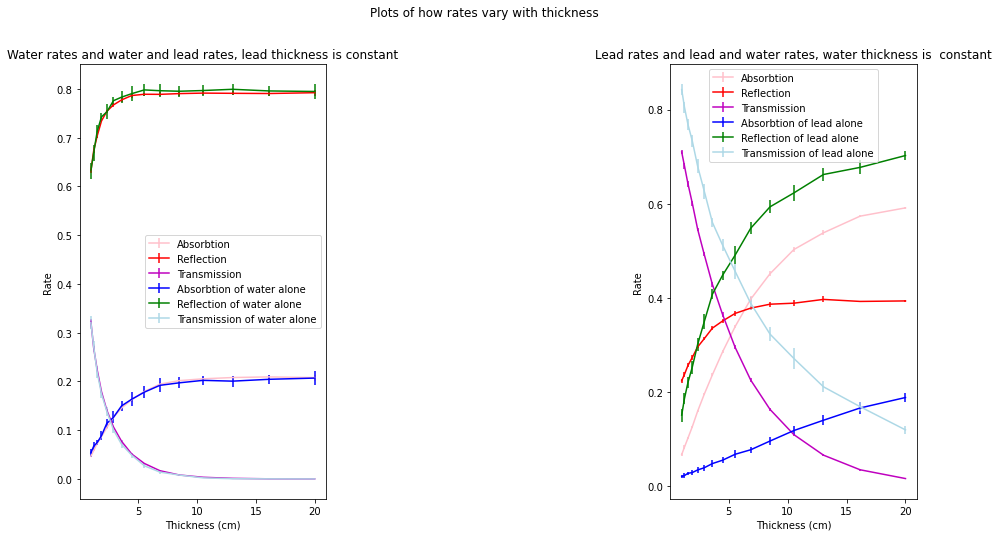

In [27]:



def thickness_plot_1(thickness_array,L2,prob_abs1,prob_abs2,macro_tot1,macro_tot2):
    #function to plot how thickness affects different rates for a given pair of materials where the first material is varied
    niter=10
    no_particles=10000
    trans_array=np.zeros(len(thickness_array))
    ref_array=np.zeros(len(thickness_array))
    abs_array=np.zeros(len(thickness_array))
    trans_array_er=np.zeros(len(thickness_array))
    ref_array_er=np.zeros(len(thickness_array))
    abs_array_er=np.zeros(len(thickness_array))

    for i in range(0,len(thickness_array)):
        abs_array[i],abs_array_er[i],ref_array[i],ref_array_er[i],trans_array[i],trans_array_er[i]=average_rates_woodcock(niter,nparticles,thickness_array[i],L2,prob_abs1,prob_abs2,macro_tot1,macro_tot2)
    return np.array([abs_array,abs_array_er,ref_array,ref_array_er,trans_array,trans_array_er])



#fix thickness of second material
L2=0.1
#plot of how rates of water-lead block vary with increasing water thickness
wl_thick=thickness_plot_1(thickness_array,L2,prob_abs_water,prob_abs_lead,macro_tot_water,macro_tot_lead)

fig_thick2=plt.figure(figsize=[15,8])
fig_thick2.suptitle('Plots of how rates vary with thickness')
axes_wl=fig_thick2.add_subplot(131)
axes_wl.errorbar(thickness_array,wl_thick[0],wl_thick[1],label='Absorbtion',color='pink')
axes_wl.errorbar(thickness_array,wl_thick[2],wl_thick[3],label='Reflection',color='red') 
axes_wl.errorbar(thickness_array,wl_thick[4],wl_thick[5],label='Transmission',color='m') 

axes_wl.errorbar(thickness_array,water_thick[0],water_thick[1],label='Absorbtion of water alone',color='blue')
axes_wl.errorbar(thickness_array,water_thick[2],water_thick[3],label='Reflection of water alone',color='green') 
axes_wl.errorbar(thickness_array,water_thick[4],water_thick[5],label='Transmission of water alone',color='lightblue') 
axes_wl.set_title('Water rates and water and lead rates, lead thickness is constant')
axes_wl.set_xlabel('Thickness (cm)')
axes_wl.set_ylabel('Rate')
axes_wl.legend(loc='best')


#plot of how rates of lead-water block vary with increasing lead thickness
lw_thick=thickness_plot_1(thickness_array,L2,prob_abs_lead,prob_abs_water,macro_tot_lead,macro_tot_water)
axes_lw=fig_thick2.add_subplot(133)
axes_lw.errorbar(thickness_array,lw_thick[0],lw_thick[1],label='Absorbtion',color='pink')
axes_lw.errorbar(thickness_array,lw_thick[2],lw_thick[3],label='Reflection',color='red') 
axes_lw.errorbar(thickness_array,lw_thick[4],lw_thick[5],label='Transmission',color='m') 

axes_lw.errorbar(thickness_array,lead_thick[0],lead_thick[1],label='Absorbtion of lead alone',color='blue')
axes_lw.errorbar(thickness_array,lead_thick[2],lead_thick[3],label='Reflection of lead alone',color='green') 
axes_lw.errorbar(thickness_array,lead_thick[4],lead_thick[5],label='Transmission of lead alone',color='lightblue') 
axes_lw.set_title('Lead rates and lead and water rates, water thickness is  constant')
axes_lw.set_xlabel('Thickness (cm)')
axes_lw.set_ylabel('Rate')
axes_lw.legend(loc='best')


plt.show()

You can see that for the block where water is placed first, that at most thicknesses, the material acts like if the lead is npt there, especially as the water thickness increases. This is because so little of the neutrons make it through the water to be absorbed, reflected or transmitted by the lead, as water increases in thickness practically no neutrons make it through to the lead, so it is almost as if we only have a block of water. In the case where lead is placed first and has varying thickness, it does match up with lead on its own, this is probably because even at 20cm lead transmitts ~ 10% of neutrons and so the water block will still have a significant affect on the rates. 

In [28]:
print("--- {:.4f} minutes ---" .format((time.time() - start_time)/60))

--- 2.1343 minutes ---
